In [1]:
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')
sys.path.append('../wdtools')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pandas as pd
import corv

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds
#import photoradius as pr

import wdtools
import corv


using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


2022-10-28 15:43:11.915877: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 15:43:11.915948: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Please install galpy if you want to use the gaia module. otherwise, ignore this.


In [2]:
sdss5_catalog = Table.read('data/sdss5/sdss5_catalog.fits')

In [3]:
#sdss5_catalog.keys()

In [4]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.bayestar import BayestarQuery

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
bsq = BayestarQuery()
ebv = bsq.query(coords)

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
print('E(B-V) = {:.3f} mag'.format(ebv))
#print(ebv)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 36.635 s
  pix_info:   1.181 s
   samples:  23.522 s
      best:   5.223 s
       nan:   0.080 s
      sort:   6.372 s
       idx:   0.256 s
E(B-V) = 0.040 mag


In [5]:
coords = [SkyCoord(frame="galactic", l=sdss5_catalog['wd_l'][i]*u.deg, b=sdss5_catalog['wd_b'][i]*u.deg, distance = (1000/sdss5_catalog['ms_parallax'][i]) * u.pc) for i in range(len(sdss5_catalog))]
sdss5_catalog['wd_coords'] = coords

In [6]:
ebv = []
flag1 = []
flag2 = []

for i in tqdm(range(len(sdss5_catalog))):
    bsq_res = bsq.query(sdss5_catalog['wd_coords'][i], return_flags = True)
        
    ebv.append(bsq_res[0])
    flag1.append(bsq_res[1][0])
    flag2.append(bsq_res[1][1])
    
sdss5_catalog['E(B-V)'] = ebv
sdss5_catalog['converged'] = flag1
sdss5_catalog['reliable_dist'] = flag2

100%|███████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 54.53it/s]


In [7]:
sdss5_catalog['u'] = [sdss5_catalog['UGRIZ'][i][0] for i in range(len(sdss5_catalog))]
sdss5_catalog['g'] = [sdss5_catalog['UGRIZ'][i][1] for i in range(len(sdss5_catalog))]
sdss5_catalog['r'] = [sdss5_catalog['UGRIZ'][i][2] for i in range(len(sdss5_catalog))]
sdss5_catalog['i'] = [sdss5_catalog['UGRIZ'][i][3] for i in range(len(sdss5_catalog))]
sdss5_catalog['z'] = [sdss5_catalog['UGRIZ'][i][4] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_u'] = [sdss5_catalog['e_UGRIZ'][i][0] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_g'] = [sdss5_catalog['e_UGRIZ'][i][1] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_r'] = [sdss5_catalog['e_UGRIZ'][i][2] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_i'] = [sdss5_catalog['e_UGRIZ'][i][3] for i in range(len(sdss5_catalog))]
sdss5_catalog['e_z'] = [sdss5_catalog['e_UGRIZ'][i][4] for i in range(len(sdss5_catalog))]

In [8]:
print(sdss5_catalog[['u', 'e_u', 'g', 'e_g','r', 'e_r', 'i', 'e_i', 'z', 'e_z']])
sdss5_catalog.remove_row(15)

    u         e_u         g         e_g          r     ...     i          e_i          z          e_z     
--------- ----------- --------- ------------ --------- ... ---------- ------------ ---------- ------------
14.598547 0.004889537 14.176811 0.0014182469 14.218766 ...  14.319564  0.001646818  14.435423 0.0039450955
 19.66774   1.1413717 17.925676   0.09239718 17.496296 ...  17.485569   0.07551573  17.609196   0.14508419
16.592285  0.01778643 15.395264 0.0035547174  14.68997 ...  14.379033 0.0020429634   14.20725 0.0027863143
22.261707   2.8734503  20.09909    0.0890704  19.17176 ...  18.877071  0.033212382  18.773474    0.0873121
17.280365  0.22542252 16.568829  0.015097296 16.306587 ...  16.276659  0.012370688  16.347094  0.020612026
18.538422   0.6392063 17.861454   0.08399587 17.505913 ...  17.378464   0.15859988   17.44168   0.21246354
17.036324 0.046184976 16.328138 0.0073797144 16.520702 ...   16.71531  0.013509237   16.86749   0.03434555
18.907745    0.120895 18.960133  0.01

In [9]:
sdss5_catalog['A_u'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_g'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_r'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_i'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_z'] = np.repeat(np.nan, len(sdss5_catalog))

sdss5_catalog['A_G'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_rp'] = np.repeat(np.nan, len(sdss5_catalog))
sdss5_catalog['A_bp'] = np.repeat(np.nan, len(sdss5_catalog))

for obj in tqdm(sdss5_catalog):
    obj['A_u'] = obj['E(B-V)'] * 3.518
    obj['A_g'] = obj['E(B-V)'] * 2.617
    obj['A_r'] = obj['E(B-V)'] * 1.971
    obj['A_i'] = obj['E(B-V)'] * 1.549
    obj['A_z'] = obj['E(B-V)'] * 1.263
    
    obj['A_G'] = obj['E(B-V)'] * 1.890
    obj['A_bp'] = obj['E(B-V)'] * 2.429
    obj['A_rp'] = obj['E(B-V)'] * 3.151
    
sdss5_catalog['dered_u'] = sdss5_catalog['u'] - sdss5_catalog['A_u']
sdss5_catalog['dered_g'] = sdss5_catalog['g'] - sdss5_catalog['A_g']
sdss5_catalog['dered_r'] = sdss5_catalog['r'] - sdss5_catalog['A_r']
sdss5_catalog['dered_i'] = sdss5_catalog['i'] - sdss5_catalog['A_i']
sdss5_catalog['dered_z'] = sdss5_catalog['z'] - sdss5_catalog['A_z']

sdss5_catalog['r_est'] = 1000 / sdss5_catalog['ms_parallax']

100%|█████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2769.66it/s]


In [10]:
import sys
import os
sys.path.append('../')
sys.path.append('../wdtools')
sys.path.append('../WD_models')
sys.path.append('../corv/src')
import WD_models

import lmfit

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['G', 'bp', 'rp'])

initialized with atm_type = H and bands = ['G', 'bp', 'rp']


In [11]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 
    
def get_model_flux(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux
    

def residual(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [12]:
def get_parameters(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):      
    obs_flux = mag_to_flux(obs_mag)
    #obs_flux = obs_mag
    
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    e_obs_flux = e_obs_mag * obs_flux
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
    
    #result.params.pretty_print()
    
    if make_plot:
        bands = ['g','bp','rp']
        
        
        
        fig = plt.figure(figsize = (8,7))
        plt.errorbar(bands, obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED')
        plt.plot(bands, get_model_flux(result.params), 'bo', markersize = 10, label = 'Model SED')
        plt.title('SED {}'.format(id_))
        plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(result.params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
        plt.xlabel('Band')
        plt.ylabel('Apparent Flux)')
        #plt.gca().invert_yaxis()
        plt.legend() 
        
        return result, fig
    
    return result

In [13]:
n_logg = 100
logg_grid = np.linspace(7.5, 9, num = n_logg)

teff_10k = lmfit.Parameters()
teff_10k.add('teff', value = 10000)
teff_10k.add('logg', value = 8)
teff_10k.add('radius', value = 0.01)
teff_10k.add('distance', value = 200)

teff_3k = lmfit.Parameters()
teff_3k.add('teff', value = 3500)
teff_3k.add('logg', value = 8)
teff_3k.add('radius', value = 0.01)
teff_3k.add('distance', value = 200)

teff_50k = lmfit.Parameters()
teff_50k.add('teff', value = 50000)
teff_50k.add('logg', value = 8)
teff_50k.add('radius', value = 0.01)
teff_50k.add('distance', value = 200)

flux_3k = get_model_flux(teff_3k)
flux_10k = get_model_flux(teff_10k)
flux_50k = get_model_flux(teff_50k)

results_10k = []
results_3k = []
results_50k = []

for logg in logg_grid:
    results_3k.append(get_parameters(flux_3k, np.array([0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))
    results_10k.append(get_parameters(flux_10k, np.array([0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))
    results_50k.append(get_parameters(flux_50k, np.array([0.03,0.03,0.03]), p0 = [10000, logg, 0.01, 200]))

In [14]:
print(sdss5_catalog.keys())

['wd_pos_id', 'solution_id1', 'solution_id2', 'source_id1', 'source_id2', 'random_index1', 'random_index2', 'ref_epoch1', 'ref_epoch2', 'ra1', 'ra2', 'ra_error1', 'ra_error2', 'dec1', 'dec2', 'dec_error1', 'dec_error2', 'parallax1', 'parallax2', 'parallax_error1', 'parallax_error2', 'parallax_over_error1', 'parallax_over_error2', 'pm1', 'pm2', 'pmra1', 'pmra2', 'pmra_error1', 'pmra_error2', 'pmdec1', 'pmdec2', 'pmdec_error1', 'pmdec_error2', 'ra_dec_corr1', 'ra_dec_corr2', 'ra_parallax_corr1', 'ra_parallax_corr2', 'ra_pmra_corr1', 'ra_pmra_corr2', 'ra_pmdec_corr1', 'ra_pmdec_corr2', 'dec_parallax_corr1', 'dec_parallax_corr2', 'dec_pmra_corr1', 'dec_pmra_corr2', 'dec_pmdec_corr1', 'dec_pmdec_corr2', 'parallax_pmra_corr1', 'parallax_pmra_corr2', 'parallax_pmdec_corr1', 'parallax_pmdec_corr2', 'pmra_pmdec_corr1', 'pmra_pmdec_corr2', 'astrometric_n_obs_al1', 'astrometric_n_obs_al2', 'astrometric_n_obs_ac1', 'astrometric_n_obs_ac2', 'astrometric_n_good_obs_al1', 'astrometric_n_good_obs_al2'

100%|███████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.09it/s]


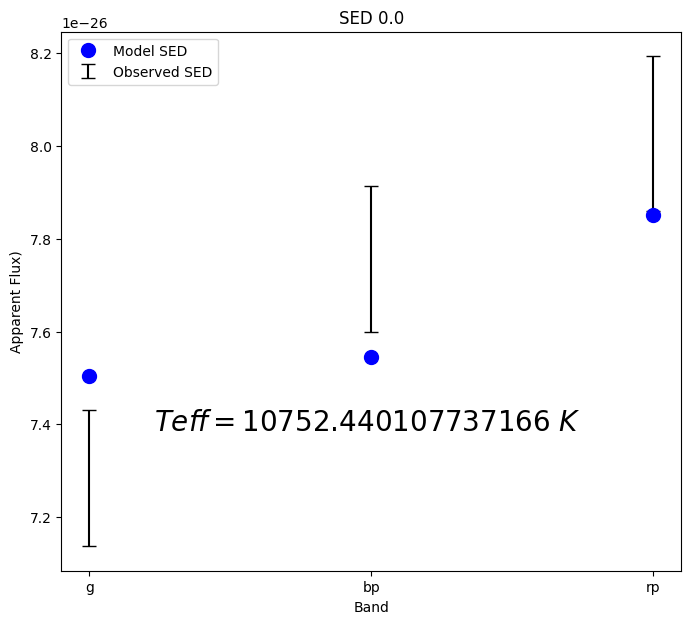

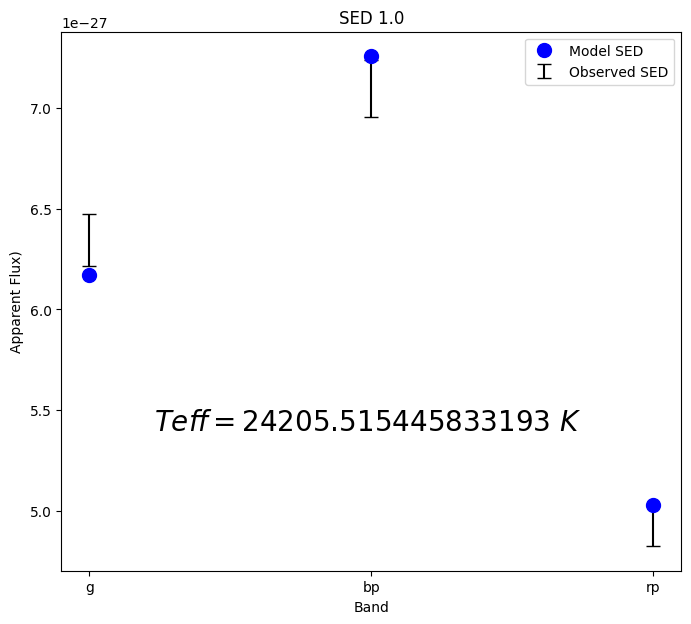

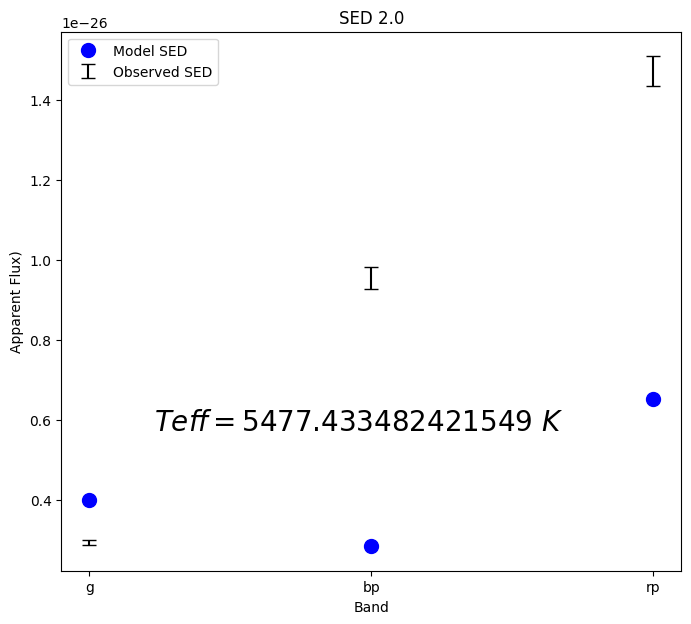

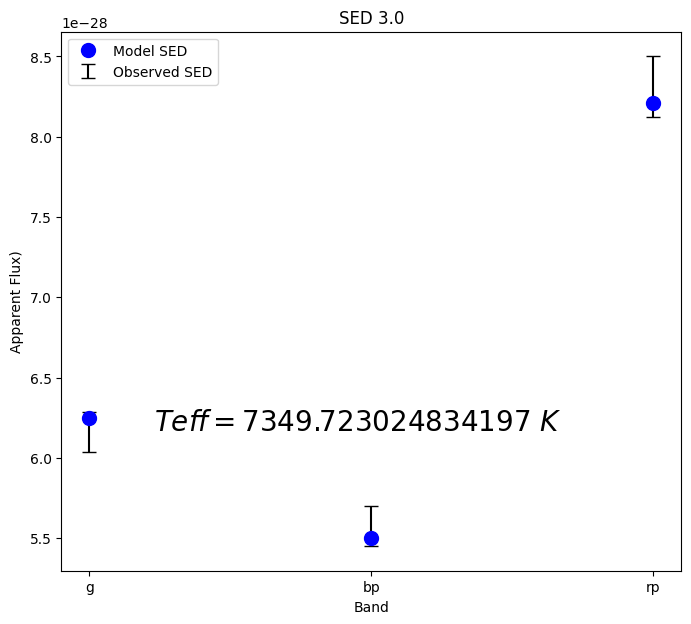

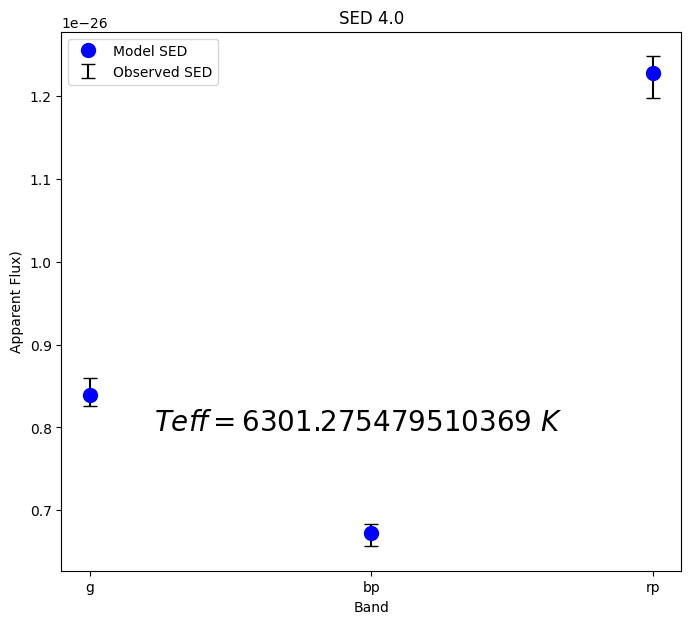

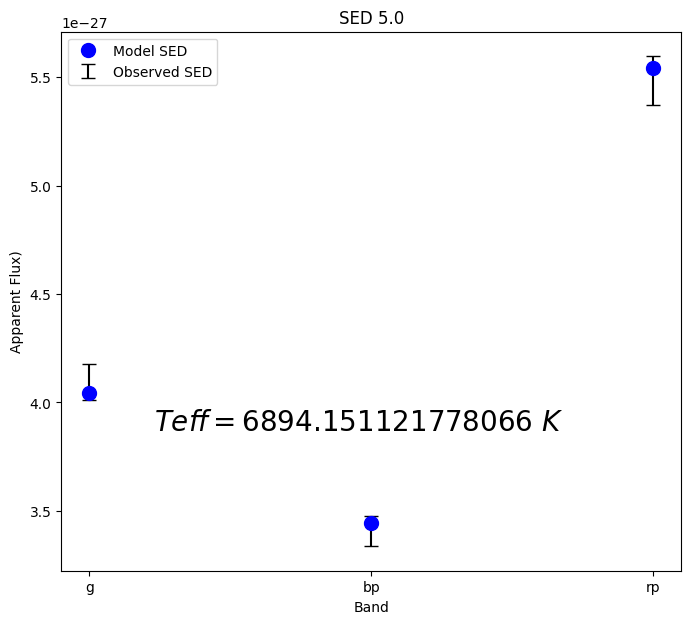

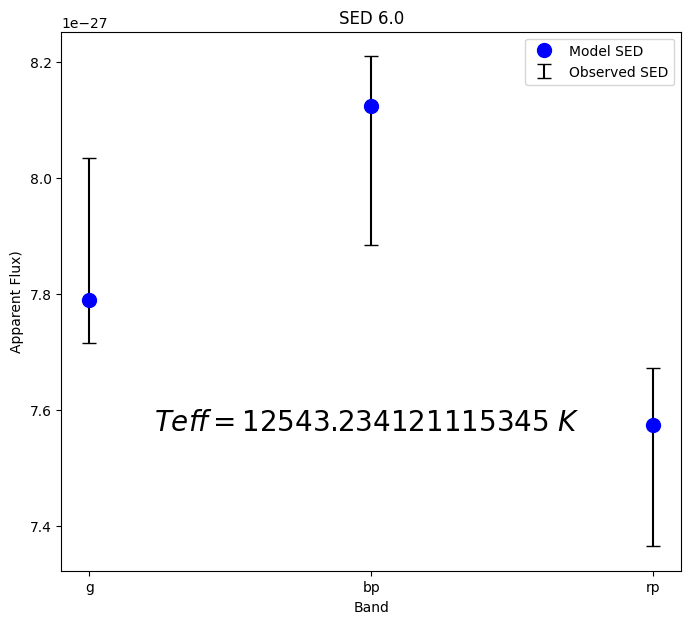

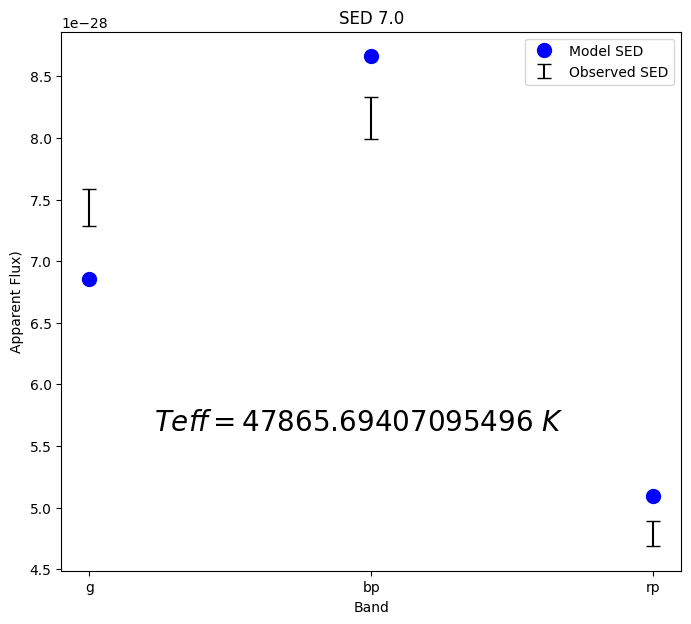

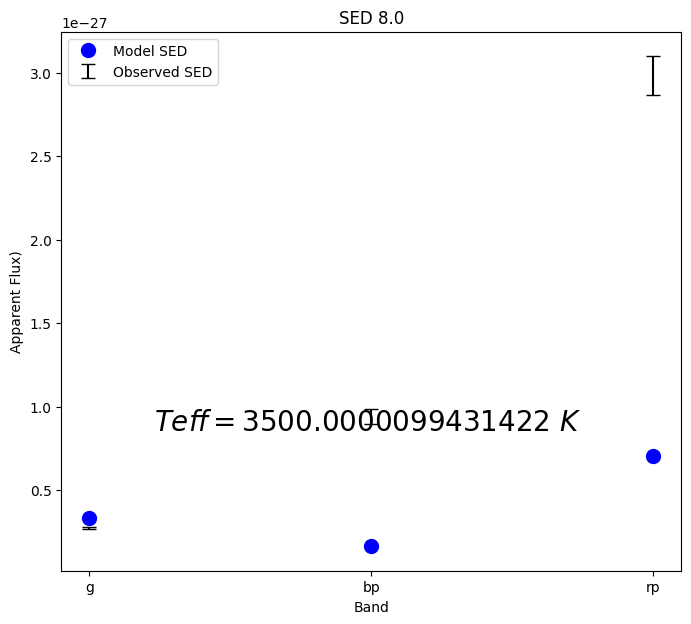

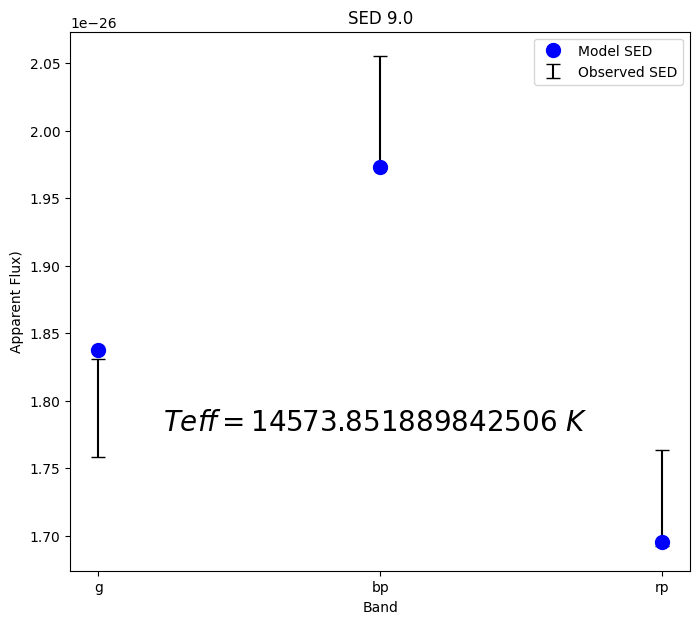

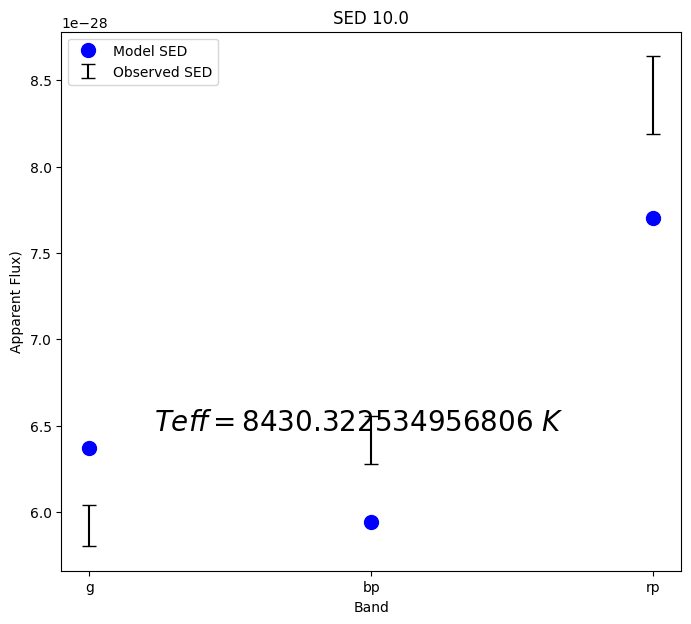

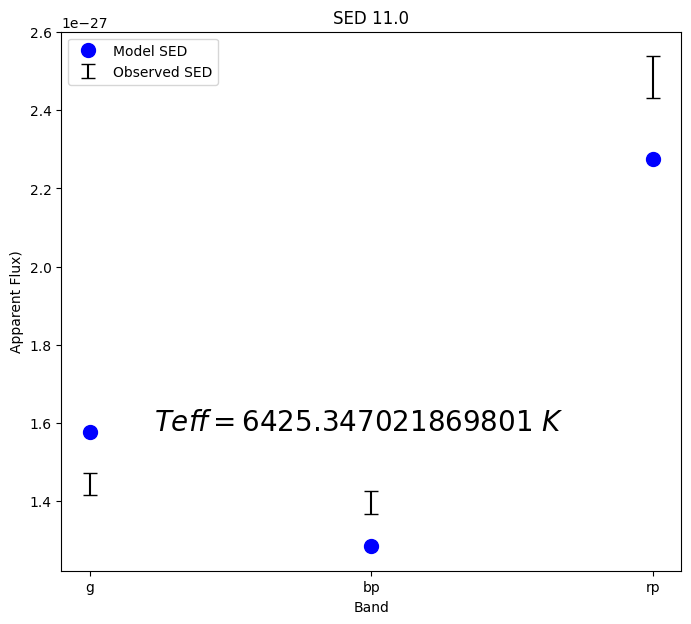

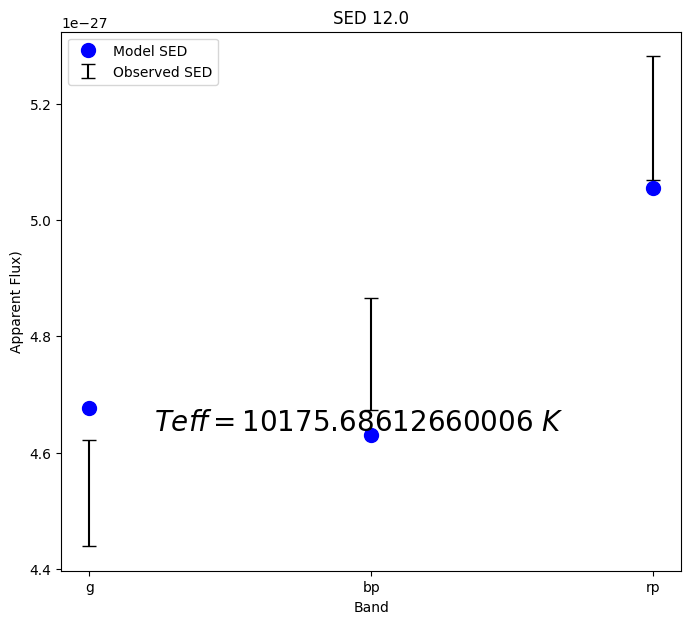

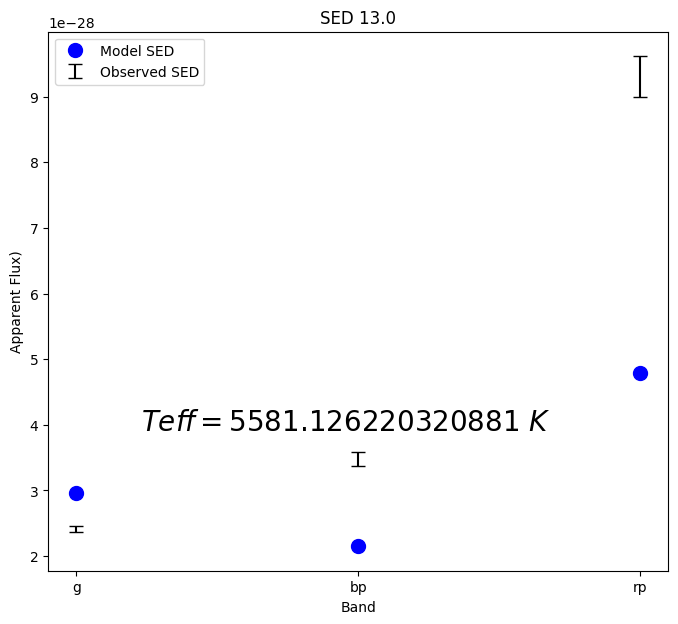

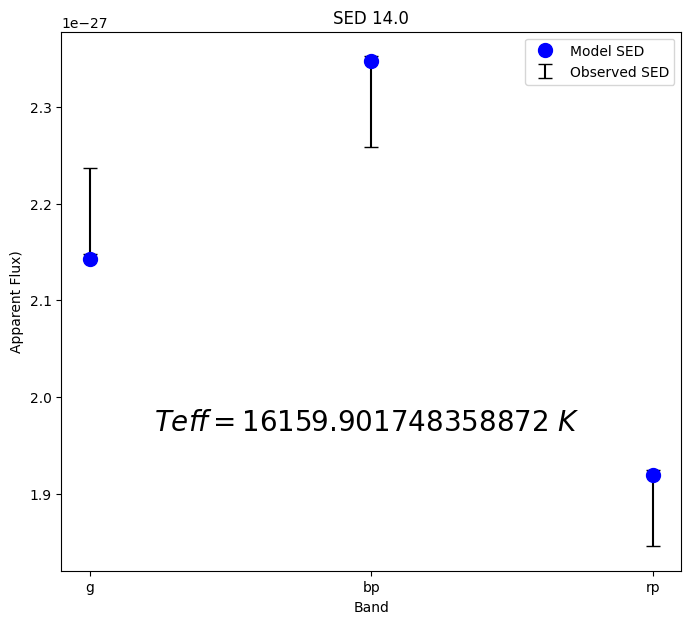

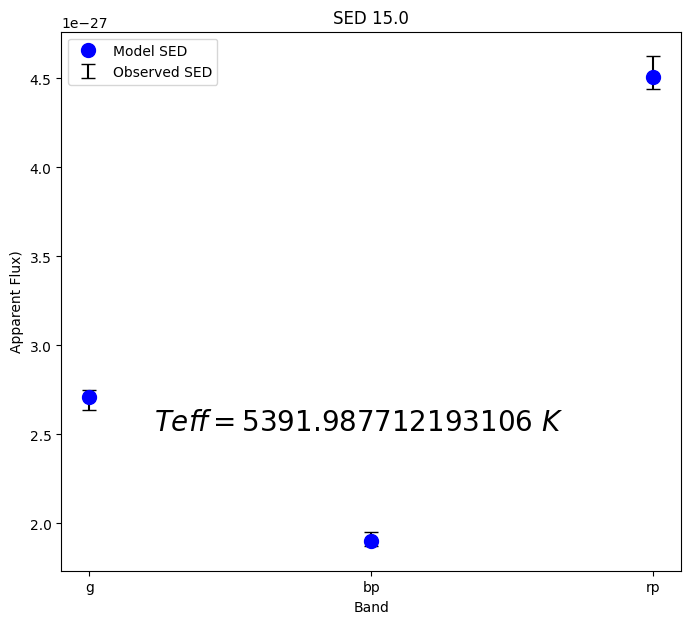

In [15]:
results = []
results7 = []
results9 = []
e_results = []

sdss5_catalog['phot_id'] = np.ones(len(sdss5_catalog))
for i in range(len(sdss5_catalog)):
    sdss5_catalog['phot_id'][i] = int(i)

plots = []

logg_vary = []

for i in tqdm(range(len(sdss5_catalog))):
    #obs_mag = np.array([sdss5_catalog['u'][i] - 0.040, sdss5_catalog['g'][i], sdss5_catalog['r'][i], sdss5_catalog['i'][i] + 0.015, sdss5_catalog['z'][i] + 0.030])
    #e_obs_mag = np.array([sdss5_catalog['e_u'][i], sdss5_catalog['e_g'][i], sdss5_catalog['e_r'][i], sdss5_catalog['e_i'][i], sdss5_catalog['e_z'][i]])
    
    obs_mag = np.array([sdss5_catalog['wd_phot_g_mean_mag'][i] - sdss5_catalog['A_G'][i], sdss5_catalog['wd_phot_bp_mean_mag'][i] - sdss5_catalog['A_bp'][i], 
                        sdss5_catalog['wd_phot_rp_mean_mag'][i] -  - sdss5_catalog['A_rp'][i]])
    
    e_G = np.sqrt((-2/5/np.log(10)*sdss5_catalog['wd_phot_g_mean_flux_error'][i]/sdss5_catalog['wd_phot_g_mean_flux'][i])**2 + 0.0027553202**2)
    e_bp = np.sqrt((-2/5/np.log(10)*sdss5_catalog['wd_phot_bp_mean_flux_error'][i]/sdss5_catalog['wd_phot_bp_mean_flux'][i])**2 + 0.0027901700**2)
    e_rp = np.sqrt((-2/5/np.log(10)*sdss5_catalog['wd_phot_rp_mean_flux_error'][i]/sdss5_catalog['wd_phot_rp_mean_flux'][i])**2 + 0.0037793818**2)
    
    e_obs_mag = np.array([e_G, e_bp, e_rp])
    
    logg7 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 7, 0.003, sdss5_catalog['r_est'][i]] )
    logg8, plot = get_parameters(obs_mag, e_obs_mag, id_ = sdss5_catalog['phot_id'][i], vary_logg=False, p0 = [10000, 8, 0.003, sdss5_catalog['r_est'][i]], make_plot = True )
    logg9 = get_parameters(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 9, 0.003, sdss5_catalog['r_est'][i]] )
    
    plots.append(plot)
    
    results.append(logg8)
    results7.append(logg7)
    results9.append(logg9)
    logg_vary.append(get_parameters(obs_mag, e_obs_mag, vary_logg = True, p0 = [10000, 8, 0.01, sdss5_catalog['r_est'][i]]))

In [16]:
vary_catalog = sdss5_catalog.copy()

sdss5_catalog['radius'] = [result.params['radius'].value for result in results]
sdss5_catalog['phot_teff'] = [result.params['teff'].value for result in results]
sdss5_catalog['e_phot_teff'] = [result.params['teff'].stderr for result in results]
sdss5_catalog['redchi'] = [result.redchi for result in results]
sdss5_catalog['e_radius'] = [np.sqrt(results[i].params['radius'].stderr**2 + np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value)**2 ) for i in range(len(results))]
sdss5_catalog['error_from_model'] = [np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value) for i in range(len(results))]

vary_catalog['radius'] = [result.params['radius'].value for result in logg_vary]
vary_catalog['teff'] = [result.params['teff'].value for result in logg_vary]
vary_catalog['e_teff'] = [result.params['teff'].stderr for result in logg_vary]
vary_catalog['redchi'] = [result.redchi for result in logg_vary]
vary_catalog['e_radius'] = [result.params['radius'].stderr for result in logg_vary]

Text(0.5, 0, 'Photometric Radius $[R_{0}]$')

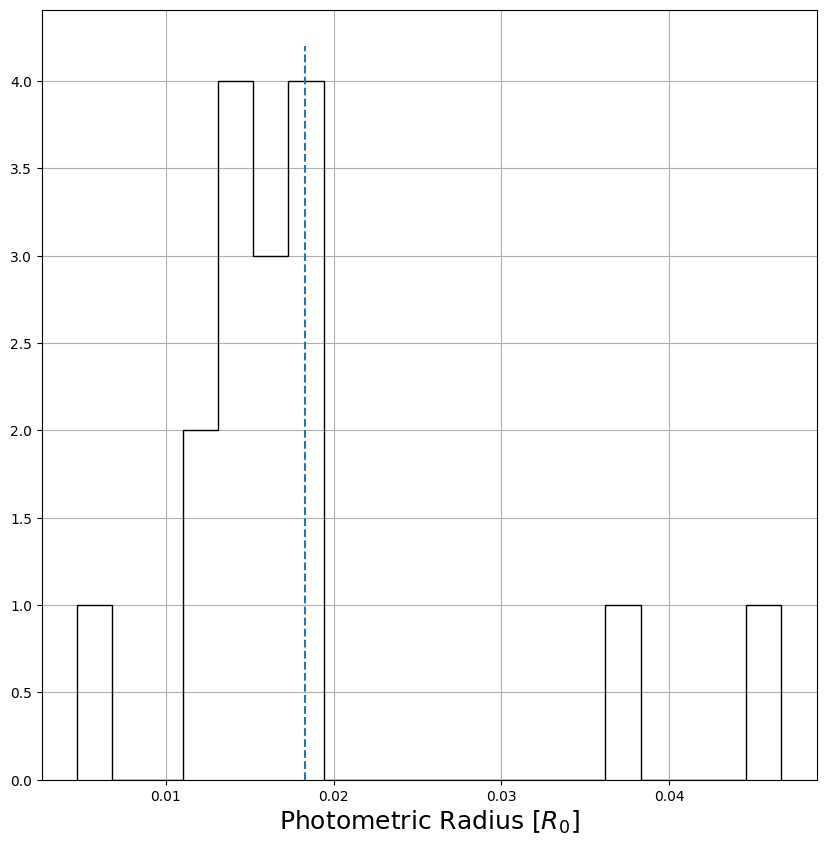

In [17]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(sdss5_catalog['radius'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(sdss5_catalog['radius']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_{0}]$', fontsize=18)
#plt.savefig('plots/photometry/radius.png')

In [18]:
nug5 = sdss5_catalog[['wd_source_id', 'phot_teff', 'e_phot_teff', 'converged', 'reliable_dist']]
nug5.write('data/sdss5/nug5.fits', overwrite = True)
sdss5_catalog.write('data/sdss5/sdss5_catalog_photo.fits', overwrite = True)